## To do

- Agree on a title naming approach (e.g. do we keep "Laugh test X:", do we want to include the main reference in the title)
- Check the expectations for this laugh test and update the image accordingly
- Agree on what constitutes relevant meta data for these things
- Update results with Reza's new ones
- Do we want the code to be more elegant in terms of extracting length of data series, convert time from the .nc attributes etc?
- Image format and specs?

# Laugh test 1: Storage and transmission in soils
This notebook plots SUMMA simulations for the test case defined in Celia et al. (1990). 

## Expectations
The simulations should reproduce Figure 6 in Celia et al. (1990):

<div>
<img src="img/celia1990_fig6.png" width="250"/>
    <center> Figure 6a in Celia et al. (1990) </center>
</div>

## Workflow
- Load model simulations (.nc) into memory
- Extract `mLayerMatricHead` and `mLayerVolFracLiq` variables for times `10`, `32` and `49`
- Create a plot of pressure head vs depth, for the selected times

## Meta data

| Data  | Value  |
|:---|:---|
| Model name| Structure for Unifying Multiple Modelling Alternatives (SUMMA) |
| Model version  |   |
| Model reference | Clark et al. (2015a,b) |
| Model runs by | M. Clark |
| Model decisions | see attributes in output.nc  |
| Model run date | see attributes in output.nc |
| Notebook code by | W. Knoben, A. Bennett |
    
## Reference(s)
Celia, M. A., E. T. Bouloutas, and R. L. Zarba (1990), A general mass conservative numerical solution for the unsaturated flow equation, Water Resour. Res., 26(7), 1483–1496, doi:10.1029/WR026i007p01483

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Rasmussen, R. M. (2015a). A unified approach for process-based hydrologic modeling: 1. Modeling concept. Water Resources Research, 51(4), 2498–2514. https://doi.org/10.1002/2015WR017198

Clark, M. P., Nijssen, B., Lundquist, J. D., Kavetski, D., Rupp, D. E., Woods, R. A., … Marks, D. G. (2015b). A unified approach for process-based hydrologic modeling: 2. Model implementation and case studies. Water Resources Research, 51, 2515–2542. https://doi.org/10.1002/2015WR017200

In [17]:
# modules
from pathlib import Path
import xarray as xr # note, also needs netcdf4 library installed
import matplotlib.pyplot as plt

In [2]:
# Specify the data locations relative to the notebook
sim_path = Path("./output")
sim_name = "celia1990_output_timestep.nc"

In [6]:
# Load the data
ds = xr.open_dataset( sim_path / sim_name )

In [7]:
# Have a look at the data
ds

<xarray.Dataset>
Dimensions:                  (gru: 1, hru: 1, ifcSoil: 101, ifcToto: 106, midSoil: 100, midToto: 105, time: 120)
Coordinates:
  * time                     (time) datetime64[ns] 2000-01-01T00:30:00.000013440 ... 2000-01-03T12:00:00
  * hru                      (hru) int32 1
Dimensions without coordinates: gru, ifcSoil, ifcToto, midSoil, midToto
Data variables:
    pptrate                  (time, hru) float64 ...
    airtemp                  (time, hru) float64 ...
    hruId                    (hru) int64 ...
    basin__SurfaceRunoff     (time, gru) float64 ...
    basin__ColumnOutflow     (time, gru) float64 ...
    basin__AquiferStorage    (time, gru) float64 ...
    basin__AquiferRecharge   (time, gru) float64 ...
    basin__AquiferBaseflow   (time, gru) float64 ...
    basin__AquiferTranspire  (time, gru) float64 ...
    averageInstantRunoff     (time, gru) float64 ...
    averageRoutedRunoff      (time, gru) float64 ...
    nSnow                    (time, hru) int32 ...
    nSoil                    (time, hru) int32 ...
    nLayers                  (time, hru) int32 ...
    scalarSWE                (time, hru) float64 ...
    mLayerTemp               (time, midToto, hru) float64 ...
    mLayerVolFracIce         (time, midToto, hru) float64 ...
    mLayerVolFracLiq         (time, midToto, hru) float64 ...
    mLayerVolFracWat         (time, midToto, hru) float64 ...
    mLayerMatricHead         (time, midSoil, hru) float64 ...
    scalarSurfaceTemp        (time, hru) float64 ...
    mLayerDepth              (time, midToto, hru) float64 ...
    mLayerHeight             (time, midToto, hru) float64 ...
    iLayerHeight             (time, ifcToto, hru) float64 ...
    scalarLAI                (time, hru) float64 ...
    scalarSAI                (time, hru) float64 ...
    scalarSenHeatTotal       (time, hru) float64 ...
    scalarLatHeatTotal       (time, hru) float64 ...
    scalarSnowSublimation    (time, hru) float64 ...
    scalarThroughfallSnow    (time, hru) float64 ...
    scalarThroughfallRain    (time, hru) float64 ...
    scalarRainPlusMelt       (time, hru) float64 ...
    scalarInfiltration       (time, hru) float64 ...
    scalarExfiltration       (time, hru) float64 ...
    scalarSurfaceRunoff      (time, hru) float64 ...
    iLayerLiqFluxSoil        (time, ifcSoil, hru) float64 ...
    mLayerLiqFluxSoil        (time, midSoil, hru) float64 ...
Attributes:
    summaVersion:     v2.0.0
    buildTime:        Tue 14 Jan 2020 14:24:01 MST
    gitBranch:        develop-0-g8258935
    gitHash:          825893588185f064ad07b9b51241ddb8b24669f6
    tmZoneInfo:       localTime
    soilStress:       NoahType
    stomResist:       BallBerry
    num_method:       itertive
    fDerivMeth:       analytic
    LAI_method:       monTable
    f_Richards:       mixdform
    groundwatr:       noXplict
    hc_profile:       constant
    bcUpprTdyn:       zeroFlux
    bcLowrTdyn:       zeroFlux
    bcUpprSoiH:       presHead
    bcLowrSoiH:       presHead
    veg_traits:       CM_QJRMS1988
    canopyEmis:       difTrans
    snowIncept:       lightSnow
    windPrfile:       logBelowCanopy
    astability:       louisinv
    canopySrad:       CLM_2stream
    alb_method:       varDecay
    snowLayers:       CLM_2010
    compaction:       anderson
    thCondSnow:       jrdn1991
    thCondSoil:       mixConstit
    spatial_gw:       localColumn
    subRouting:       timeDlay
    notPopulatedYet:  notPopulatedYet

In [20]:
# Extract the variables we want
matricHead = ds.mLayerMatricHead
layerHeight = ds.mLayerHeight

In [26]:
# Select the time slices of interest
matricHead_t10 = matricHead.isel(time=10)
matricHead_t32 = matricHead.isel(time=32)
matricHead_t49 = matricHead.isel(time=49)

layerHeight_t10 = layerHeight.isel(time=10)
layerHeight_t32 = layerHeight.isel(time=32)
layerHeight_t39 = layerHeight.isel(time=49)

In [44]:
# Ensure that we can actually read the figure labels
font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

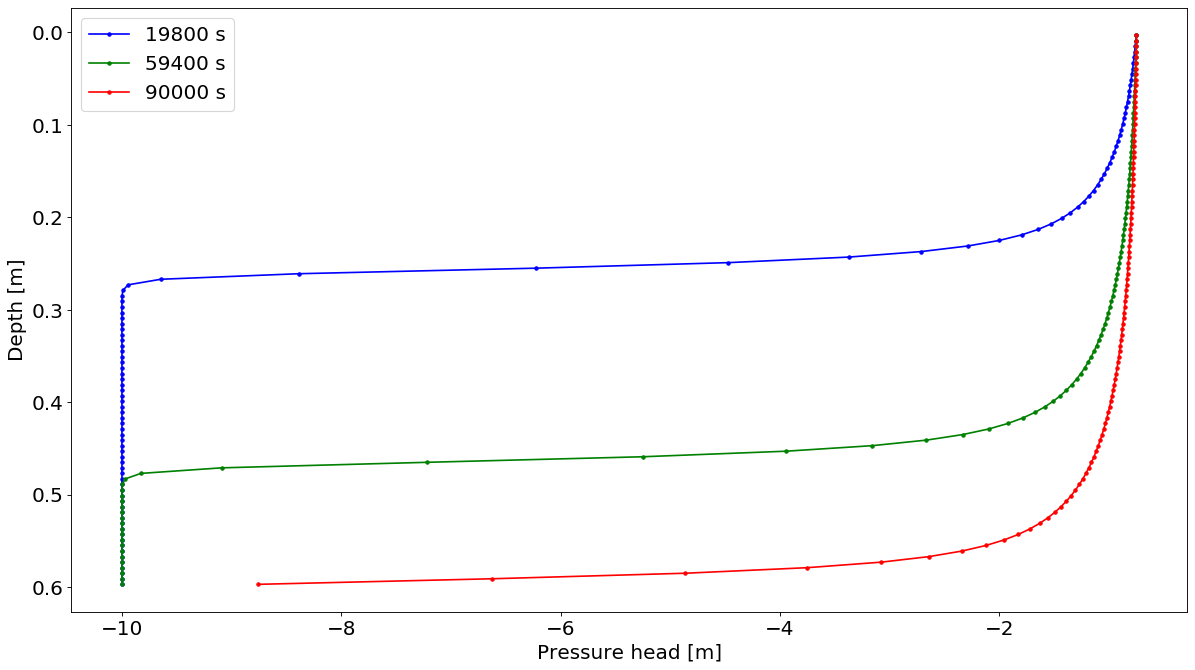

In [50]:
# Open a figure
fig = plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k');

# Plot the data in a single figure
plt.plot(matricHead_t10[0:100], layerHeight_t10[0:100], marker='.', color='blue',  label='19800 s')
plt.plot(matricHead_t32[0:100], layerHeight_t32[0:100], marker='.', color='green', label='59400 s')
plt.plot(matricHead_t49[0:100], layerHeight_t39[0:100], marker='.', color='red',   label='90000 s')

# Make sure that increasing depth points downward
plt.gca().invert_yaxis()

# Labels
plt.xlabel('Pressure head [m]'); # note, ';' supresses output from the Text object that is created for the labels
plt.ylabel('Depth [m]');
plt.legend();

# Save the figure
plt.savefig('img/lt1_celia1990.png');